In [1]:
import numpy as np
import pandas as pd
import os
import statistics

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

import preprocessing

pd.set_option('display.max_columns', 500)
warnings.filterwarnings(action = 'ignore')

# 1. Data Load

In [2]:
train_original = pd.read_csv('data/train.csv')
test_original = pd.read_csv('data/test.csv')
weather = pd.read_csv('data/weather_hour.csv', encoding = 'cp949')

train = train_original.copy()
test = test_original.copy()

In [3]:
train = preprocessing.make_sum_column(train)
test = preprocessing.make_sum_column(test)

train = preprocessing.time_data(train)
test = preprocessing.time_data(test)

* 데이터의 전처리를 위해 preprocessing 함수 설계
* make_sum_column: 전체 가구의 전기사용량을 시간별로 합산
* time_data : Time column에서 시간, 날짜, 월, 년의 정보를 추출

**Train data 수집기간 : 2016/07/26 ~ 2018/06/30**  
**Weather data 수집기간 : 2016/07/20 ~ 2018/07/01**  
**따라서 2016/07/27 ~ 2018/06/30의 데이터만을 사용**

In [4]:
train = train.iloc[13 : ]
weather = weather.iloc[168 : 17063]

# 2. Data Preprocessing

**train, test, weather 데이터가 존재하고, 예측해야하는 Y는 test의 전기 사용량**  
**가장 Y와 연관성이 큰 변수들을 파악하고 이들을 사용하기 좋게 가공**

## 2-1. Identify data trends

**모든 가구의 전기 사용량을 시간대별로 합산하여 시간에 따른 전체 전기사용량의 추세를 파악**

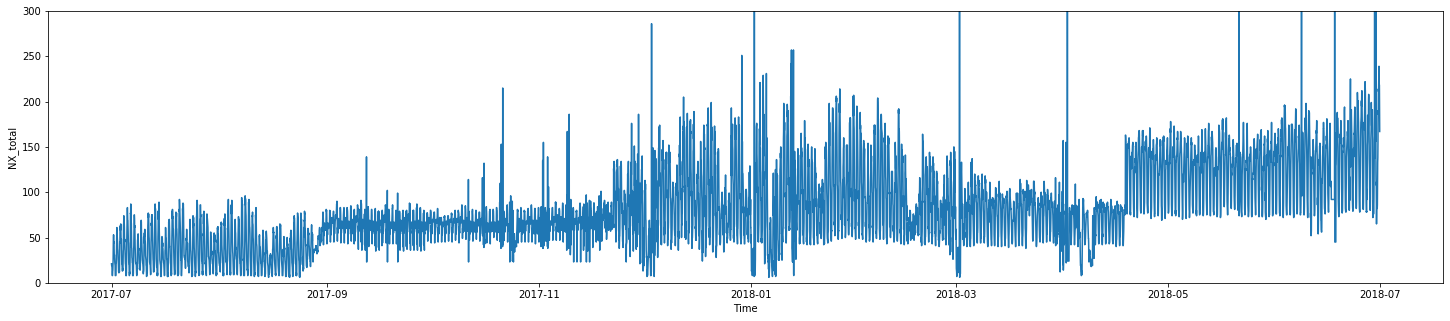

In [5]:
fig, ax = plt.subplots(1, 1, figsize = (25, 5))

sns.lineplot(x = 'Time', y = 'NX_total', ax = ax, data = test)
plt.ylim(0, 300)
plt.show()

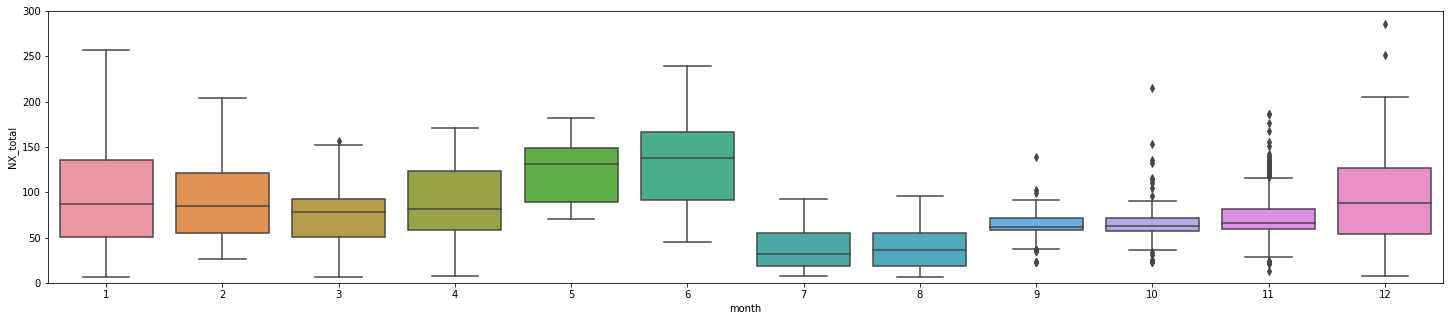

In [6]:
fig, ax = plt.subplots(1, 1, figsize = (25, 5))

sns.boxplot(x = 'month', y = 'NX_total', ax = ax, data = test)
plt.ylim((0, 300))
plt.show()

**일반적인 통념과는 다르게 여름의 초입인 6월에 가장 전기 사용량이 많고 가장 더운 7, 8월에 전기 사용량이 급감하는 것으로 파악**  
**위의 line plot을 통해 7, 8월의 데이터량이 부족하여 발생한 문제라고 결론**

## 2-2. NULL 값 파악 

**2016년 7월부터 데이터를 수집하였으나 대부분의 데이터는 2017년 8월 이후로 수집이 진행됨.**  
**전체 기간의 데이터를 파악하기 위해 가장 Null값이 적은 가정을 추출**

In [7]:
null_count = [0] * (train_original.shape[1] -1)
for length in range(train_original.shape[1] - 1) :
    null_count[length] = sum(train_original.iloc[ : , length + 1].isnull())

In [8]:
column = train_original.columns[1 : ]
null_counts = pd.DataFrame({'columns' :column, 
                           'null_count' : null_count})
null_counts.describe()

,null_count
count,1300.000000
mean,13054.977692
std,2421.513256
min,0.000000
25%,13842.000000
50%,13846.500000
75%,13873.250000
max,16909.000000


In [9]:
null_under_7500 = null_counts[null_counts['null_count'] < 7500]
null_under_7500.sort_values(by = ['null_count'])

,columns,null_count
1184,NX1185,0
1174,NX1175,0
1043,NX1044,0
237,NX238,0
282,NX283,0
680,NX681,0
382,NX383,0
330,NX331,25
989,NX990,46
214,NX215,55


**Null 값이 하나도 존재하지 않는 가구는 총 7가구**  
**그 중 5개의 가구를 골라 이후 feature engineering에 활용**

* NX1185
* NX1175 	
* NX238 	
* NX681
* NX383 	

In [21]:
valuable_house = ['NX1185', 'NX1175', 'NX238', 'NX681', 'NX383']

## 2-3. Feature Engineering

**전기 사용량과 가장 상관관계가 높은 변수를 추출**

In [11]:
weather

,지점,일시,기온(°C),강수량(mm),풍속(m/s),습도(%),적설(cm),날씨,전운량(10분위)
168,112,2016.7.27 0:00,26.6,NaN,3.1,98.0,NaN,구름조금,5.0
169,112,2016.7.27 1:00,26.5,NaN,3.1,98.0,NaN,NaN,NaN
170,112,2016.7.27 2:00,26.3,NaN,3.5,98.0,NaN,NaN,NaN
171,112,2016.7.27 3:00,26.1,NaN,4.2,98.0,NaN,박무,8.0
172,112,2016.7.27 4:00,26.1,NaN,4.7,98.0,NaN,흐림,9.0
...,...,...,...,...,...,...,...,...,...
17058,112,2018.6.30 18:00,27.2,NaN,2.5,72.0,NaN,연무,9.0
17059,112,2018.6.30 19:00,26.5,NaN,1.8,77.0,NaN,NaN,NaN
17060,112,2018.6.30 20:00,24.5,NaN,2.4,80.0,NaN,NaN,NaN
17061,112,2018.6.30 21:00,24.5,NaN,3.6,79.0,NaN,구름많음,8.0


**통상적으로 기온은 전기사용량과 매우 높은 상관관계를 가질것으로 파악**  
**지점, 전운량은 직관적으로 상관없을 것으로 판단하고 날씨 또한 다른 데이터들을 통해 파악가능하므로 제외**

In [12]:
weather = weather.iloc[ : , 1 : 7]
weather.columns = ['Time', 'Temperature', 'precipitation', 'Wind_speed', 'Humid', 'Snow']
weather['Time'] = pd.to_datetime(weather['Time'])

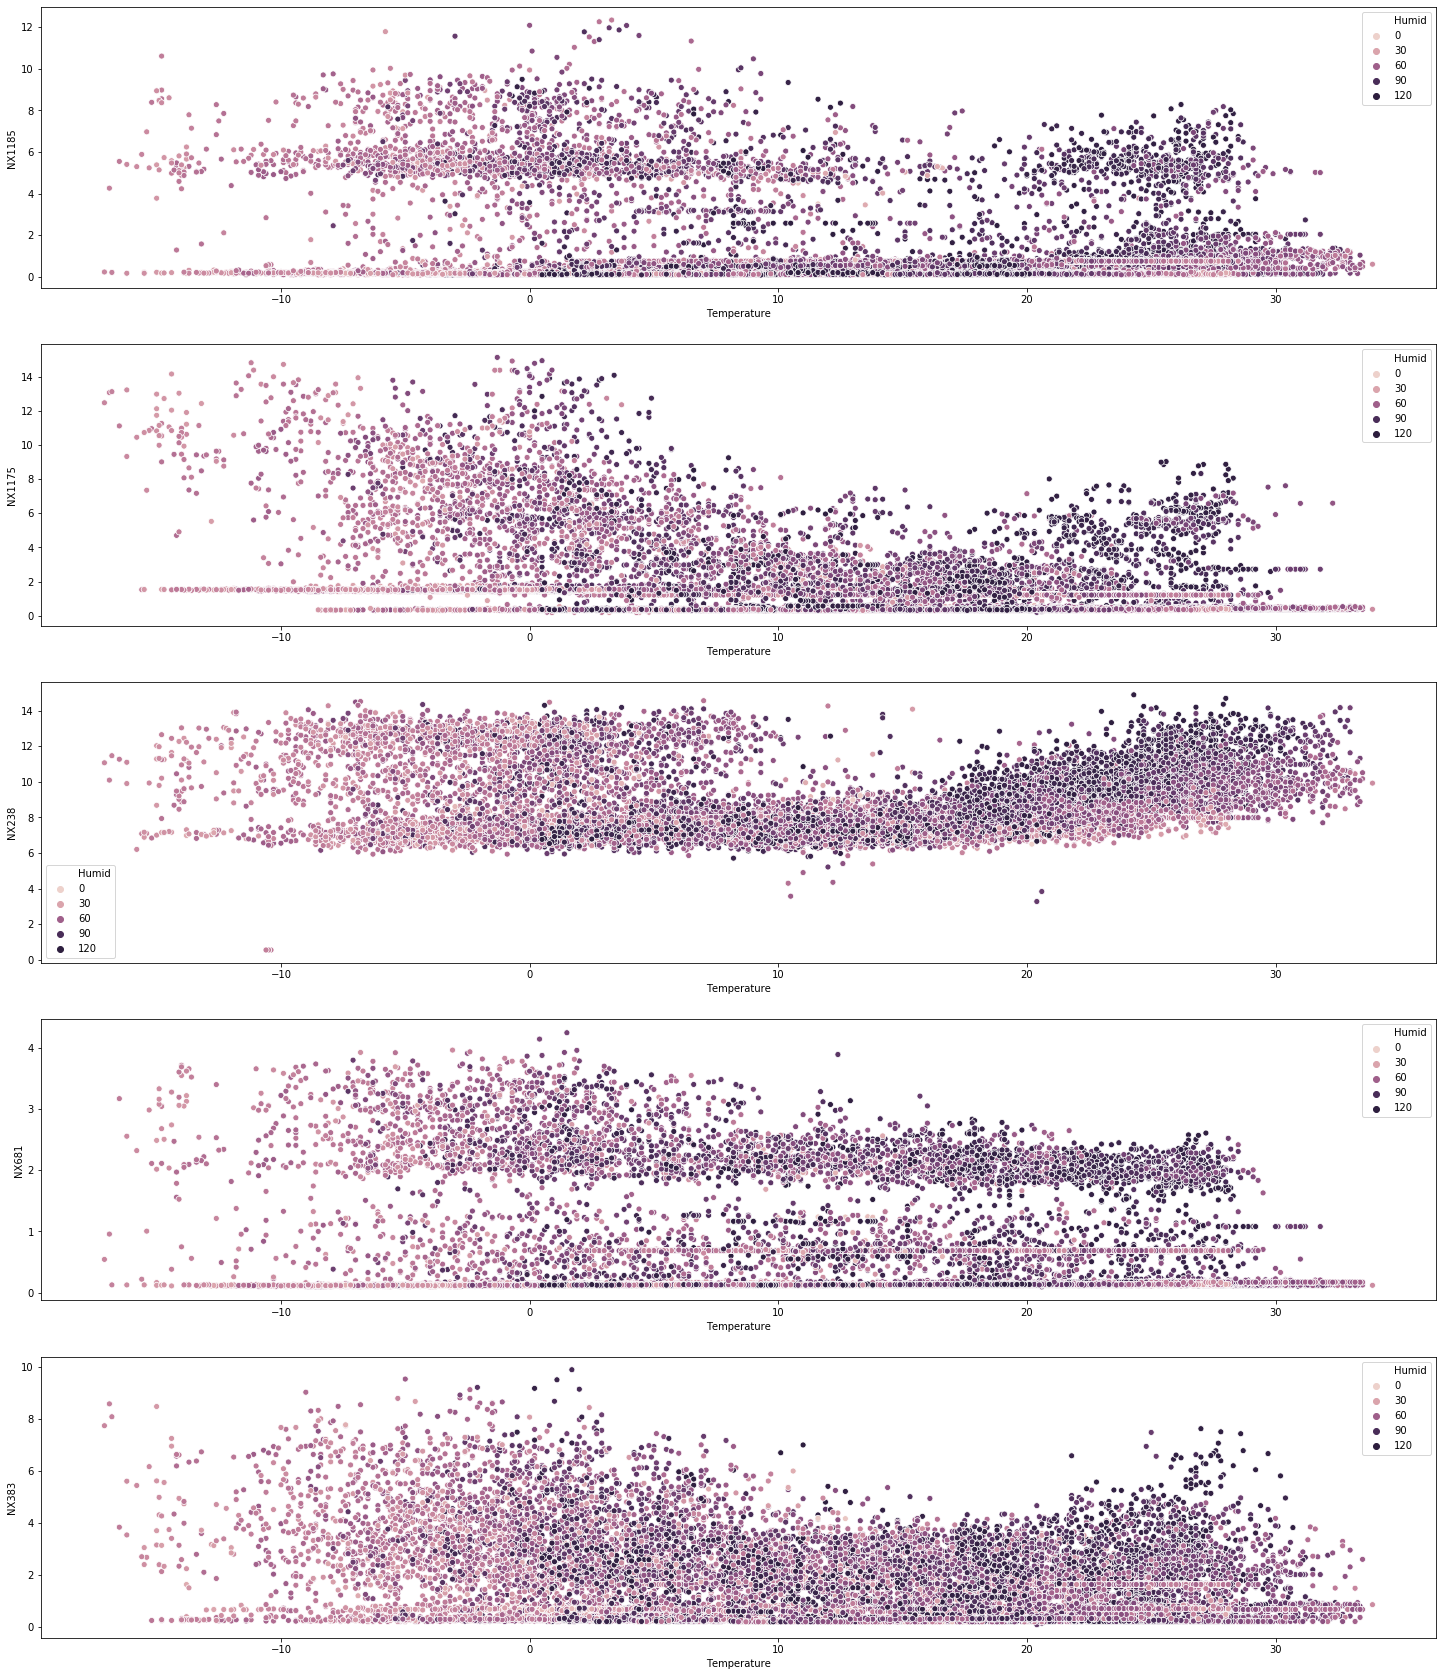

In [13]:
fig, ax = plt.subplots(5, 1, figsize = (25, 30))

sns.scatterplot(x = weather['Temperature'], y = train['NX1185'], hue = weather['Humid'], ax = ax[0])
sns.scatterplot(x = weather['Temperature'], y = train['NX1175'], hue = weather['Humid'], ax = ax[1])
sns.scatterplot(x = weather['Temperature'], y = train['NX238'], hue = weather['Humid'], ax = ax[2])
sns.scatterplot(x = weather['Temperature'], y = train['NX681'], hue = weather['Humid'], ax = ax[3])
sns.scatterplot(x = weather['Temperature'], y = train['NX383'], hue = weather['Humid'], ax = ax[4])
plt.show()


**기온과 강한 상관관계가 있을 것이라는 예상과 달리 NX238 가정을 제외하면 기온에 따른 전기량 사용의 증가는 눈에 띄게 보이지 않음**  
**습도 또한 큰 영향이 없음을 plot을 통해 확인 가능**  
**자세한 분석을 위해 correlation 계산**

In [34]:
train_weather = pd.merge(train, weather, on = 'Time')
valuable_house.append('Time')
train_weather_value = pd.merge(train[valuable_house], weather, on ='Time')
valuable_house.pop()
train_weather_value.set_index(['Time'])

,NX1185,NX1175,NX238,NX681,NX383,Temperature,precipitation,Wind_speed,Humid,Snow
Time,,,,,,,,,,
2016-07-27 00:00:00,0.759,0.427,13.721,0.125,0.797,26.6,NaN,3.1,98.0,NaN
2016-07-27 01:00:00,0.829,0.423,11.626,0.126,0.801,26.5,NaN,3.1,98.0,NaN
2016-07-27 02:00:00,1.128,0.386,11.225,0.125,0.799,26.3,NaN,3.5,98.0,NaN
2016-07-27 03:00:00,0.885,0.386,11.580,0.125,0.799,26.1,NaN,4.2,98.0,NaN
2016-07-27 04:00:00,0.767,0.386,10.117,0.123,0.410,26.1,NaN,4.7,98.0,NaN
...,...,...,...,...,...,...,...,...,...,...
2018-06-30 18:00:00,0.112,0.325,7.984,0.478,2.748,27.2,NaN,2.5,72.0,NaN
2018-06-30 19:00:00,0.162,0.390,11.326,0.298,2.660,26.5,NaN,1.8,77.0,NaN
2018-06-30 20:00:00,0.113,0.446,10.126,0.133,2.956,24.5,NaN,2.4,80.0,NaN


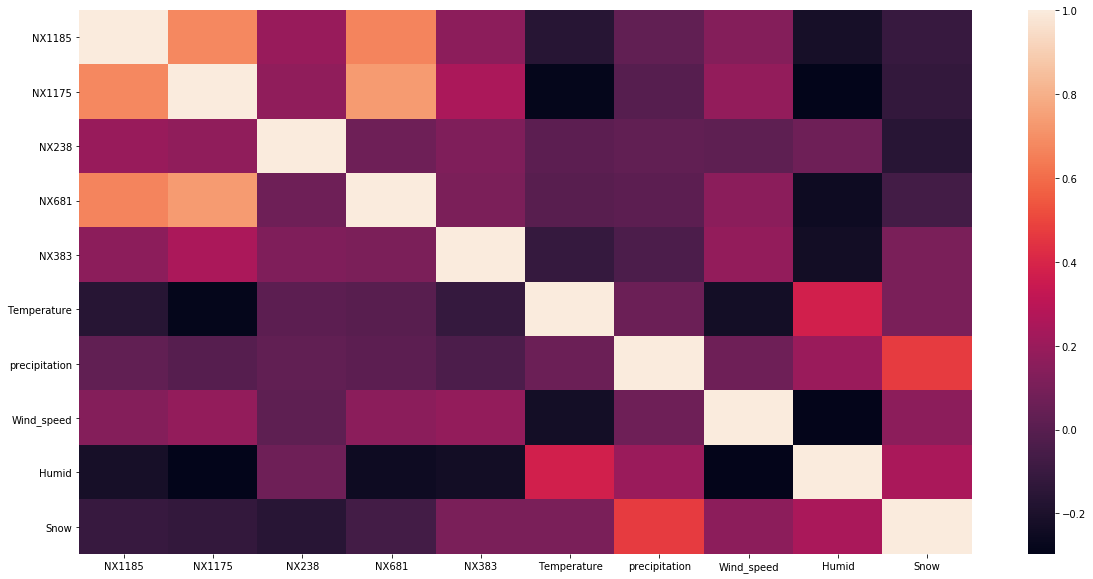

In [38]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
sns.heatmap(train_weather_value.corr(), ax = ax)

**히트맵을 통해 살펴본 결과 본 데이터에서 날씨 데이터와 전기사용량은 전혀 아무상관이 없다.**  
**따라서 날씨 데이터를 모두 버리고 전력 데이터만을 이용하여 예측을 진행**

# 3. Generating model